# (PINN) -> 

# Example n = 1 polytropique -> Equation to be solved ...


# Used to make Figures 5 and 6 in Paper ...
## Environment set up

We train the PINN using PyTorch, using the following environment set up:
```bash

conda create -n pinn python=3
conda activate pinn
conda install jupyter numpy matplotlib
conda install pytorch torchvision torchaudio -c pytorch
```



In [23]:
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [24]:
# ..............
def solut(x):
    # True Solution ....
    # n =1 ....
    y= np.sin(x)/x    
    return y

def solutder(x):
    # True first order derivative ....
    yd= np.cos(x)/x - np.sin(x)/x**2    
    return yd


class FCN(nn.Module):
    "Defines a connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

## Generate training data

> First, we generate some training data from a small part of the true solution.


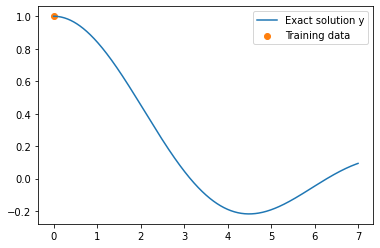

In [25]:
# get the analytical solution over the full domain ....
x = torch.linspace(0,7.,700).view(-1,1)
y = solut(x).view(-1,1)
yderiv = solutder(x).view(-1,1)

# ... slicing the true solution at x=0
x_data=x[0:700:700]
y_data=y[0:700:700]
y_data[0]=1.

plt.figure()
plt.plot(x, y, label="Exact solution y")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()


## Normal neural network

> Next, we train a standard neural network (fully connected network) to fit these training points.

>We find that the network is able to fit the solution very closely in the vicinity of the training points, but does not learn an accurate solution outside of them.

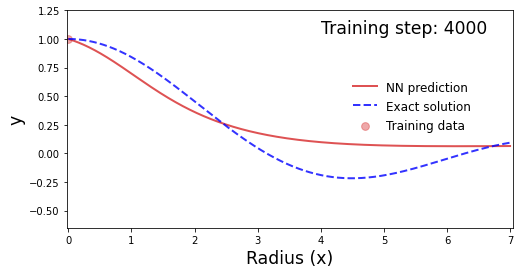

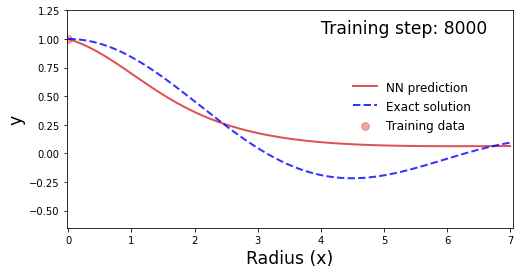

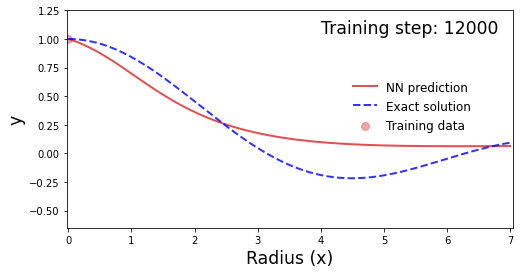

In [26]:
def plot_result(x,y,x_data,y_data,yh,xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    plt.plot(x,yh, color="tab:red", linewidth=2, alpha=0.8, label="NN prediction")
    plt.plot(x,y, color="blue", linewidth=2, alpha=0.8,linestyle='--',label="Exact solution")
    plt.scatter(x_data, y_data, s=60, color="tab:red", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=30, color="tab:green", alpha=0.4, 
                    label='Collocation points')
    l = plt.legend(loc=(0.63,0.42), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.025, 7.05)
    plt.ylim(-0.65, 1.25)
    plt.text(4.,1.05,"Training step: %i"%(i+1),fontsize="xx-large",color="k")
    plt.ylabel('y',fontsize="xx-large")
    plt.xlabel('Radius (x)',fontsize="xx-large")
    plt.axis("on")
        
# train standard neural network to fit training data ..................
torch.manual_seed(123)
model = FCN(1,1,20,2)
optimizer = torch.optim.Adam(model.parameters(),lr=3e-3)
files = []
loss11_history = []

for i in range(12000):
    optimizer.zero_grad()
    yh = model(x_data)
  
    loss = torch.mean((yh-y_data)**2)  # use mean squared error
    loss.backward()
    optimizer.step()
    
    
    # plot the result as training progresses ......................
    if (i+1) % 100 == 0: 
        loss11_history.append(loss.detach())  
        yh = model(x).detach()
              
        plot_result(x,y,x_data,y_data,yh)
        
    
        if (i+1) % 4000 == 0: plt.show()
        else: plt.close("all")
            


## PINN

> Finally, we add the underlying differential equation ("physics loss") to the loss function. 

The physics loss aims to ensure that the learned solution is consistent with the underlying differential equation. This is done by penalising the residual of the differential equation over a set of locations sampled from the domain.

Here we evaluate the physics loss at ...

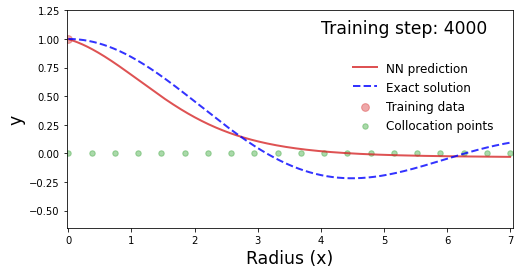

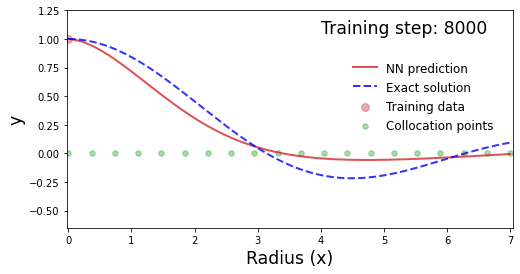

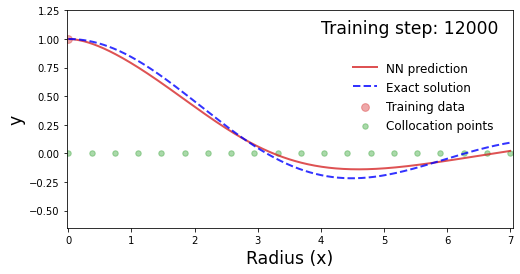

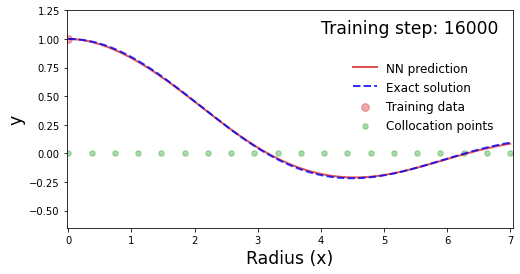

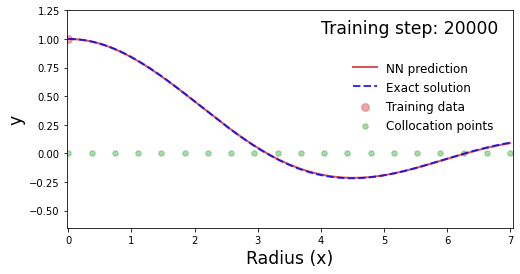

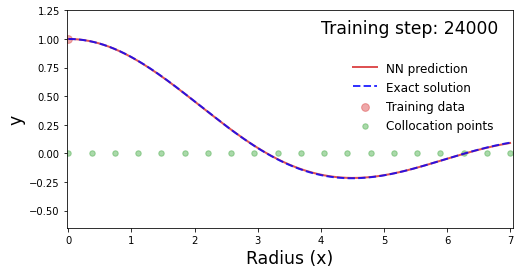

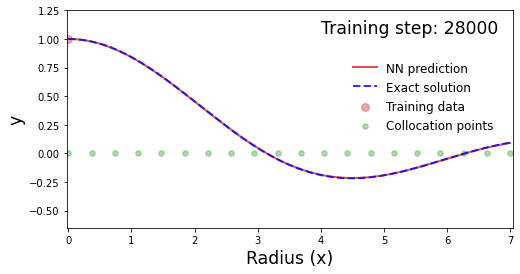

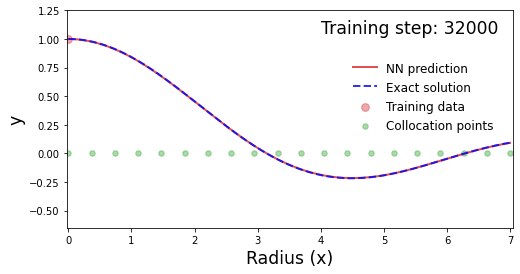

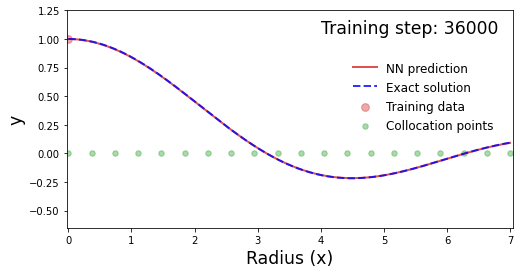

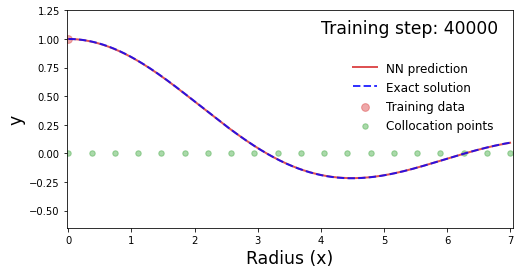

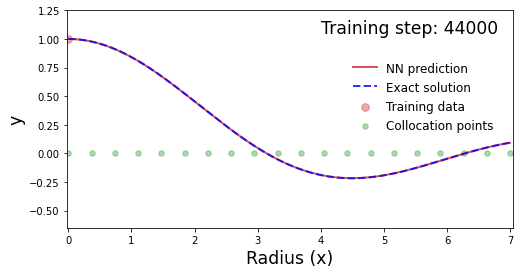

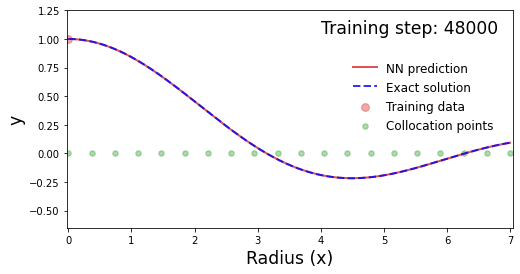

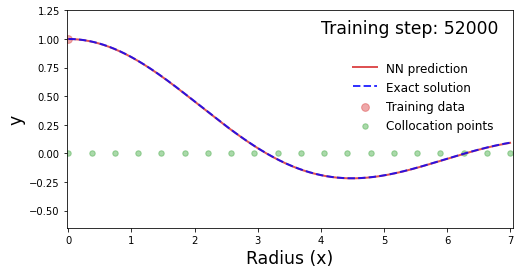

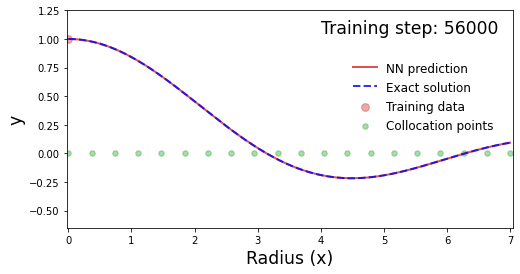

SystemExit: 

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3452: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


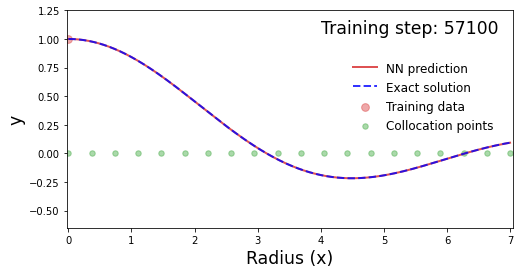

In [27]:
import sys
# We choose the colocation points for physics ......................................
x_physics = torch.linspace(0,7.,20).view(-1,1).requires_grad_(True)# sample locations over the problem domain

indic=1
# We initialize pseudo-randomly the hyper-parameters ... note that it could influence the details of the results
# if you modify the value between parenthesis ..............
torch.manual_seed(777)
model = FCN(1,1,20,2)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
files = []

loss_history = []
loss2_history = []
loss1_history = []
mse_history =[]

for i in range(126000):
    optimizer.zero_grad()
    
    # We compute the "data loss" .............................................
    yh = model(x_data)
    loss1 = 1.*torch.mean((yh-y_data)**2)# use mean squared error
      
    # We compute the "physics loss" .............................................
    yhp = model(x_physics)
    
    dx = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]  
    dxx = torch.autograd.grad(dx, x_physics, torch.ones_like(dx), create_graph=True)[0] 
    
    # Add the constraint on first order derivative .....
    loss1 = loss1 + 0.01*(dx[0]**2)
    
    # Residual and Loss for physics ......... 
    physics = x_physics*dxx + 2*dx + x_physics*yhp**indic        
    loss2 = (2e-2)*(torch.mean(physics**2))
    
    # We backpropagate total loss ................................................
    loss = loss1 + loss2# add two loss terms together
    loss.backward()
    optimizer.step()
    
    
    # We plot the result as training progresses ....................................
    if (i+1) % 100 == 0:
        loss_history.append(loss.detach())
        loss2_history.append(loss2.detach())
        loss1_history.append(loss1.detach())
    
        yh = model(x).detach()
        
        xp = x_physics.detach()        
        plot_result(x,y,x_data,y_data,yh,xp)
        
        mse= torch.mean((yh-y)**2)
        mse_history.append(mse.detach())
        
        if mse < 2.e-8: sys.exit()
                
        if (i+1) % 4000 == 0: plt.show()
        else: plt.close("all")
            
            
    
            

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


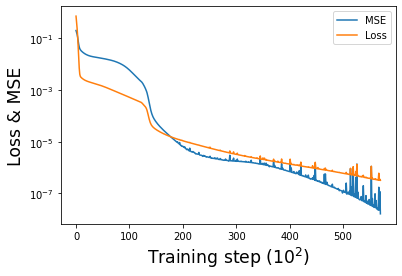

In [28]:
plt.plot(mse_history,label='MSE')
plt.plot(loss_history,label='Loss')
plt.xlabel('Training step ($10^2$)',fontsize="xx-large")
plt.ylabel('Loss & MSE',fontsize="xx-large")
plt.yscale('log')
plt.legend()

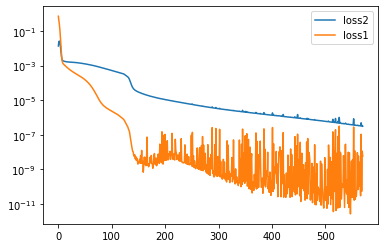

In [29]:
plt.plot(loss2_history, label="loss2")
plt.plot(loss1_history, label="loss1")
plt.yscale('log')
plt.legend()

Text(0.5, 1.0, 'error on der')

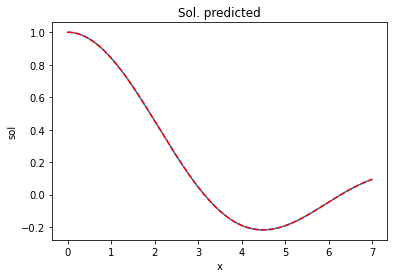

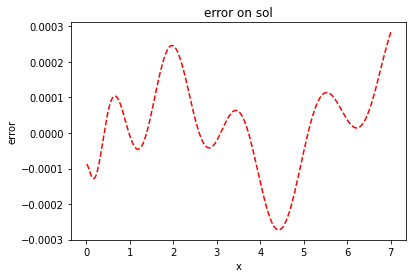

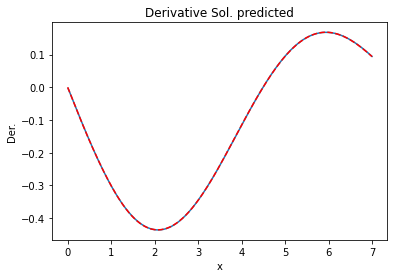

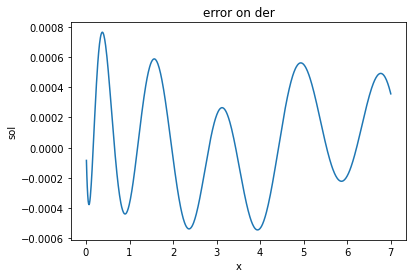

In [30]:
xn = torch.linspace(0,7,700).view(-1,1)
xn2 = torch.linspace(0,7,700).view(-1,1).requires_grad_(True)#

yff = model(xn2)

# We deduce the predicted first order derivative ..........
der = torch.autograd.grad(yff, xn2, torch.ones_like(yff), create_graph=True)[0]
deriv= der.detach().numpy()

ypre = model(xn).detach()

# plot extrapolate    
fig5 = plt.figure(5)
plt.plot(xn, ypre)
plt.plot(xn, y,'r--')
plt.xlabel("x")
plt.ylabel("sol")
plt.title("Sol. predicted")

fig6 = plt.figure(6)
plt.plot(xn, y-ypre,'r--')
plt.xlabel("x")
plt.ylabel("error")
plt.title("error on sol")

fig7 = plt.figure(7)
plt.plot(xn, yderiv)
plt.plot(xn, deriv,'r--')
plt.xlabel("x")
plt.ylabel("Der.")
plt.title("Derivative Sol. predicted")

fig8 = plt.figure(8)
plt.plot(xn, yderiv-deriv )
plt.xlabel("x")
plt.ylabel("sol")
plt.title("error on der")

#print(xn),(y-ypre)

In [31]:
print ( torch.mean((y-ypre)**2) )

tensor(1.6249e-08)


Text(0.5, 1.0, 'Absolute error on solution and derivative')

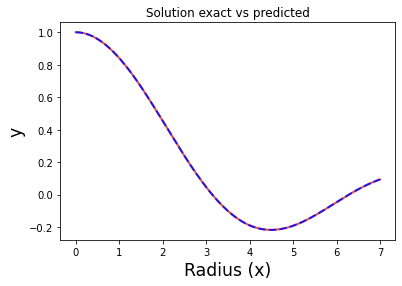

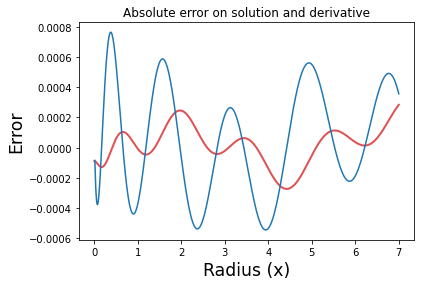

In [32]:
# plot extrapolate    
fig5 = plt.figure(5)
plt.plot(xn, ypre,color="tab:red", linewidth=2, alpha=0.8, label="NN prediction")
plt.plot(xn, y,color="blue", linewidth=2, alpha=0.8,linestyle='--',label="Exact solution")
plt.ylabel('y',fontsize="xx-large")
plt.xlabel('Radius (x)',fontsize="xx-large")
plt.title("Solution exact vs predicted")

fig6 = plt.figure(6)
plt.plot(xn, y-ypre,color="tab:red", linewidth=2, alpha=0.8, label="error on y")
plt.ylabel('Error',fontsize="xx-large")
plt.xlabel('Radius (x)',fontsize="xx-large")
plt.plot(xn, yderiv-deriv )
plt.title("Absolute error on solution and derivative")